In [1]:
set.seed(42)
train_set = read.delim("data/train_set.txt", sep = " ")
test_set = read.delim("data/test_set.txt", sep = " ")

train_set["rain"] = NULL
train_set["rain_log"] = NULL

test_set["rain"] = NULL
test_set["rain_log"] = NULL

train_set[,"rain_class"] = as.factor(train_set[,"rain_class"])
test_set[,"rain_class"] = as.factor(test_set[,"rain_class"])

In [2]:
exp_var = setdiff(names(train_set), c("rain"))
exp_var

[1] "ff"           "t"            "td"           "hu"           "dd"          
 [6] "precip_log"   "ws_arome"     "p3031_arome"  "u10_arome"    "v10_arome"   
[11] "t2m_arome"    "d2m_arome"    "r_arome"      "tp_arome_log" "msl_arome"   
[16] "rain_class"   "month2"       "month3"       "month4"       "month5"      
[21] "month6"       "month7"       "month8"       "month9"       "month10"     
[26] "month11"      "month12"

In [3]:
MAPE = function(y, y_hat){
    # y = as.numeric(y)
    # y_hat = as.numeric(y_hat)
    mape = 100*mean(abs((y - y_hat)/y))
    return(mape)
}

MSE = function(y, y_hat){
    mse = mean((y - y_hat)**2)
    return(mse)
}

confusion_matrix = function(pred_class, true_class){
    tab = table(pred_class, true_class)
    print("Confusion matrix")
    print(tab)
    acc = sum(diag(tab)) / sum(tab)
    print(paste("Prediction accuracy : ", acc))
}

In [4]:
library(glmnet)
library(Rcpp)
library(ellipse)
library(leaps)
library(MASS)

library(plotly)
library(ggplot2)     
library(gridExtra)   
library(ggfortify)   
library(ggcorrplot) 

library(dplyr)

Loading required package: Matrix

Loaded glmnet 4.1-4


Attaching package: 'ellipse'


The following object is masked from 'package:graphics':

    pairs


Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout



Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




## 4. Support Vector Machine

In [5]:
x_train = as.matrix(train_set[, exp_var])
x_test = as.matrix(test_set[, exp_var])

y_train = as.factor(train_set[,"rain_class"])
y_test = as.factor(test_set[,"rain_class"])

In [6]:
library(e1071)
library(rpart)

### 4.1. Linear Support Vector Machine Classification

In [7]:
linear.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'linear', cost = 10)
summary(linear.svm)


Call:
svm(formula = rain_class ~ ., data = train_set, type = "C", kernel = "linear", 
    cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  470

 ( 204 115 151 )


Number of Classes:  3 

Levels: 
 high_rain low_rain no_rain




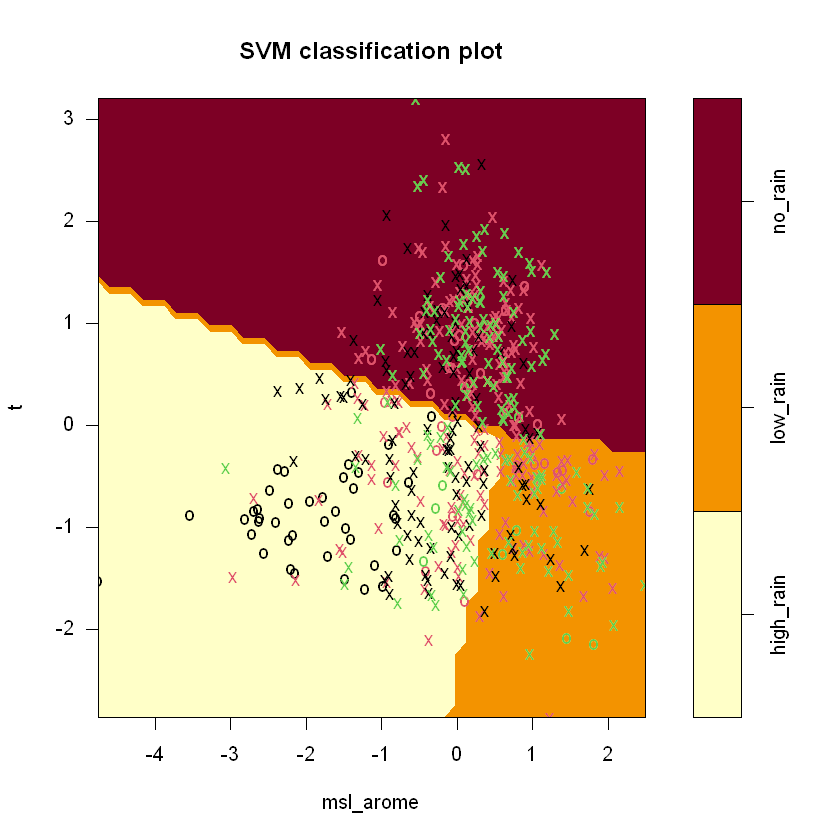

In [8]:
plot(linear.svm, data = train_set, t ~ msl_arome)

In [9]:
confusion_matrix(predict(linear.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        21        9       7
  low_rain         11       41      25
  no_rain           1        8      15
[1] "Prediction accuracy :  0.557971014492754"


### Hyperparameter tuning

In [13]:
linear.svm.tune = tune.svm(rain_class ~ ., data = train_set, type = "C", kernel = 'linear', cost = seq(0.5, 10, by = 0.5), gamma = seq(0.01, 0.1, by = 0.01))


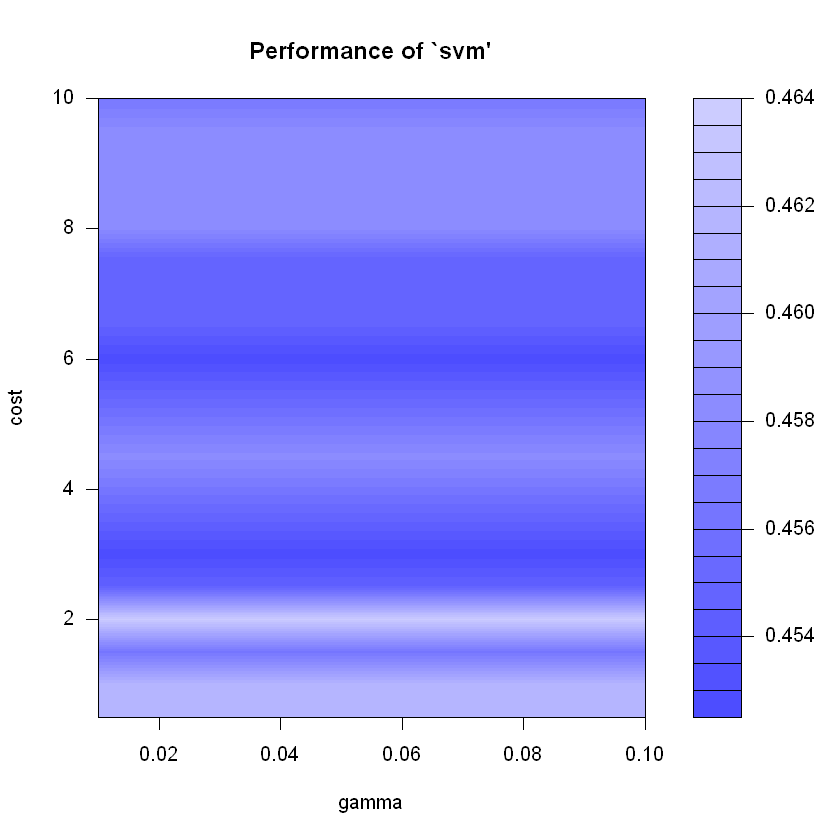

In [14]:
plot(linear.svm.tune)

In [15]:
linear.svm.tune$best.parameters$gamma
linear.svm.tune$best.parameters$cost

[1] 0.01

[1] 3